In [1]:
library(Seurat)
library(patchwork)
library(tidyverse)
library(magrittr)
library(future)

set.seed(1515)
options(future.globals.maxSize = 80000 * 1024^2)
plan("multicore", workers = 16)
plan()

Attaching SeuratObject

Attaching sp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




multicore:
- args: function (..., workers = 16, envir = parent.frame())
- tweaked: TRUE
- call: plan("multicore", workers = 16)

In [2]:
combined <- readRDS("/workdir/wangph/proj/20220418_TB/SC/5.seurat/v7-12sample-normal/1.2.merged-raw-20220811.rds")
dim(combined)

[1]  23668 155645

In [3]:
combined = subset(x = combined, prediction.Scrublet == 'False')
dim(combined)

[1]  23668 153071

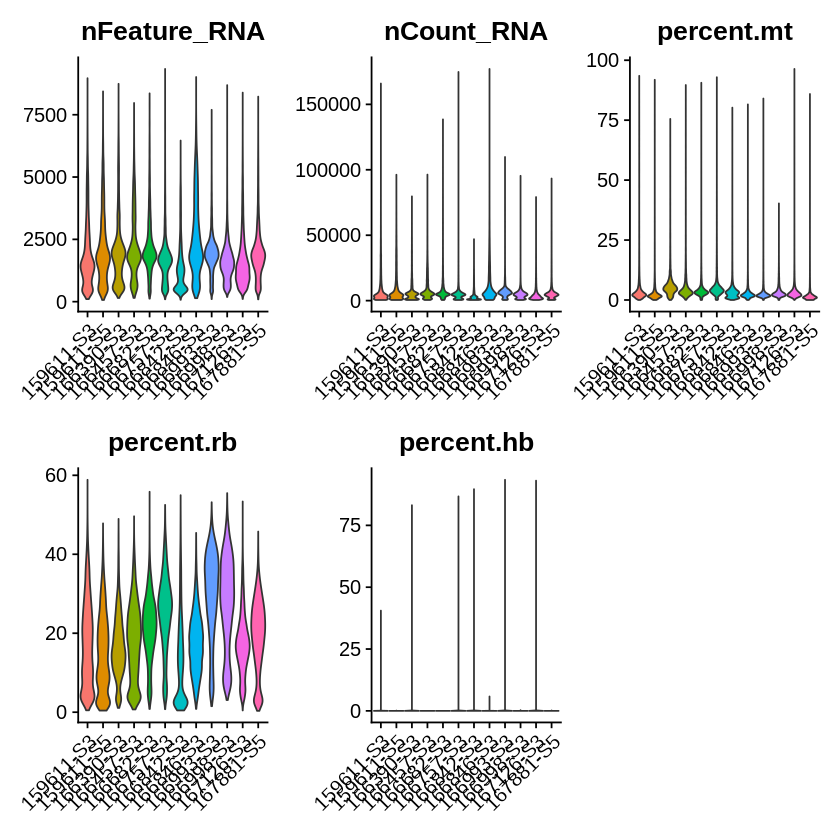

In [4]:
### 绘制质控小提琴图
# 设置可能用到的主题
theme.set2 = theme(axis.title.x=element_blank())
# 设置绘图元素
plot.featrures = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb", "percent.hb")
group = "sample"
# 质控前小提琴图
plots = list()
for(i in seq_along(plot.featrures)){
  plots[[i]] = VlnPlot(combined, group.by=group, pt.size = 0,
                       features = plot.featrures[i]) + theme.set2 + NoLegend()}
violin <- wrap_plots(plots = plots, nrow=2)    
violin

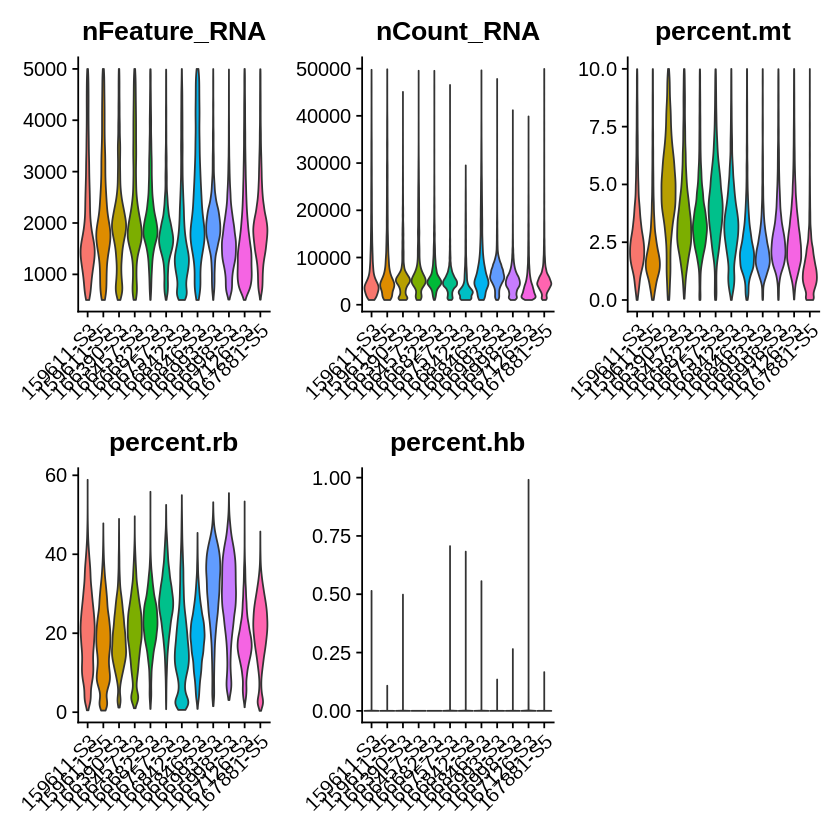

In [5]:
### 设置质控标准
minGene=500
maxGene=5000
minUMI=1000
maxUMI=50000
pctMT=10
pctHB=1

### 数据质控并绘制小提琴图
combined <- subset(combined, subset = nCount_RNA > minUMI & nCount_RNA < maxUMI & 
                   nFeature_RNA > minGene & nFeature_RNA < maxGene & 
                   percent.mt < pctMT & percent.hb < pctHB)
plots = list()
for(i in seq_along(plot.featrures)){
  plots[[i]] = VlnPlot(combined, group.by=group, pt.size = 0,
                       features = plot.featrures[i]) + theme.set2 + NoLegend()}
violin <- wrap_plots(plots = plots, nrow=2)     
violin

In [6]:
combined
summary(combined@meta.data$nFeature_RNA)
summary(combined@meta.data$nCount_RNA)

An object of class Seurat 
23668 features across 127703 samples within 1 assay 
Active assay: RNA (23668 features, 0 variable features)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    501    1302    1760    1933    2313    4999 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1001    3060    4826    6458    7258   49932 

In [7]:
# 降维聚类
combined <- NormalizeData(combined) %>% FindVariableFeatures(nfeatures = 3000) %>% ScaleData()
# combined <- SCTransform(combined, return.only.var.genes = FALSE)

Centering and scaling data matrix



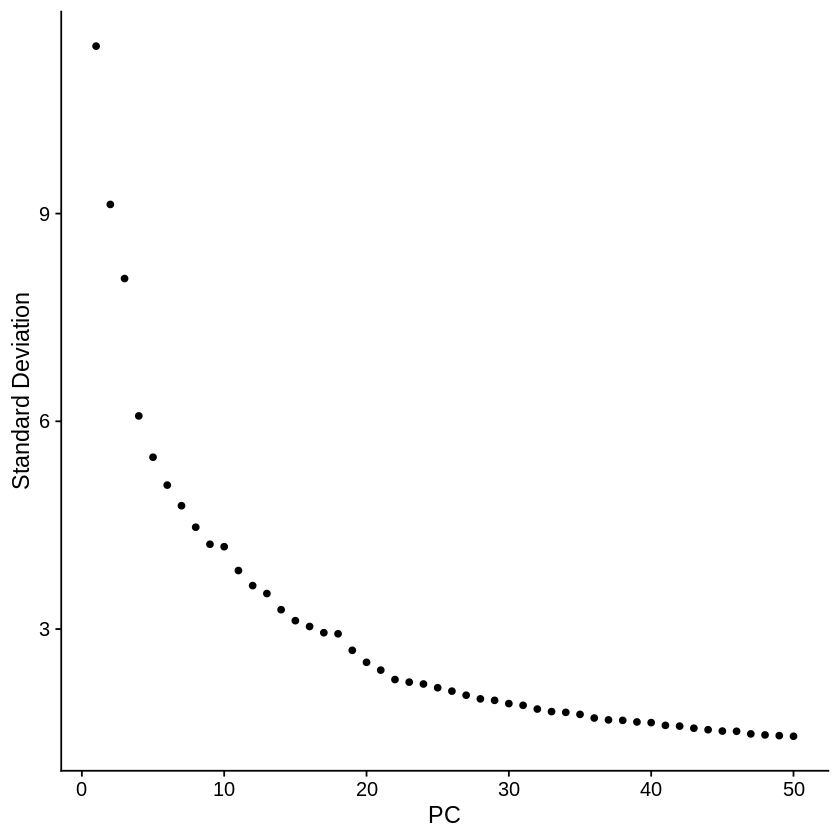

In [8]:
combined <- RunPCA(combined, verbose = F)
ElbowPlot(combined, ndims = 50)

In [9]:
saveRDS(combined, file = "/workdir/wangph/proj/20220418_TB/SC/5.seurat/v7-12sample-normal/2.1.merged-processed-nodoublet-20220812.rds")

In [10]:
pc.num=1:30
combined <- combined %>% RunTSNE(dims=pc.num) %>% RunUMAP(dims=pc.num)
combined <- FindNeighbors(combined, dims=pc.num) %>% FindClusters()

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
00:26:00 UMAP embedding parameters a = 0.9922 b = 1.112

00:26:00 Read 127703 rows and found 30 numeric columns

00:26:00 Using Annoy for neighbor search, n_neighbors = 30

00:26:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:26:22 Writing NN index file to temp file /tmp/RtmpxwH0nN/file5fcb36e54bb9d

00:26:22 Searching Annoy index using 16 threads, search_k = 3000

00:26:28 Annoy recall = 100%

00:26:30 Commencing smooth kNN distance calibration using 16 threads
 with target n_neig

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 127703
Number of edges: 4436409

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9406
Number of communities: 40
Elapsed time: 135 seconds


1 singletons identified. 39 final clusters.

Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



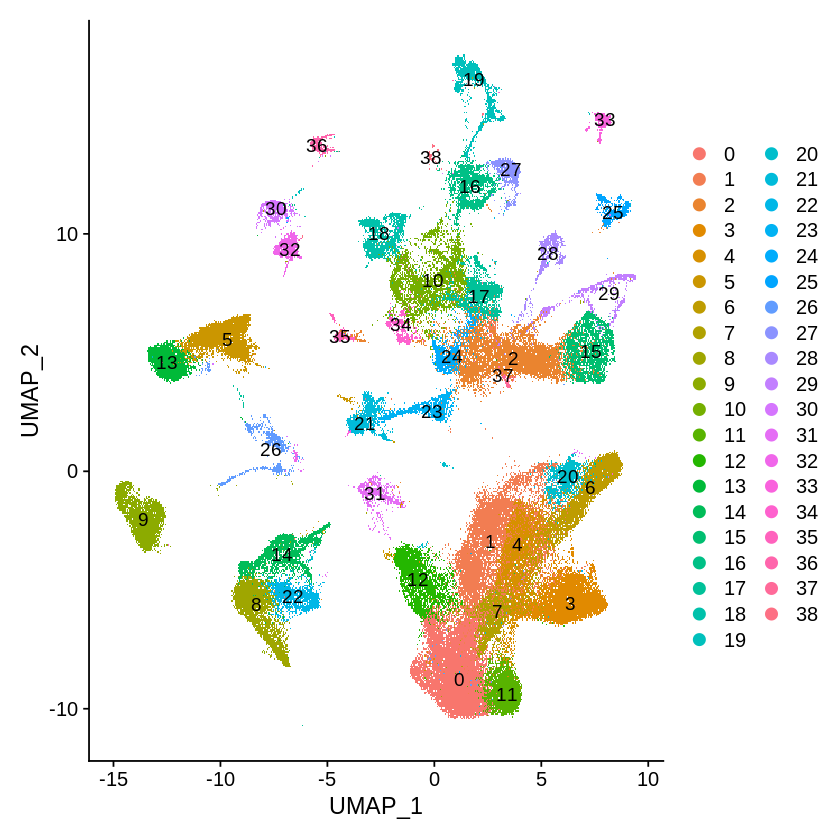

In [11]:
DimPlot(combined, label = T)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



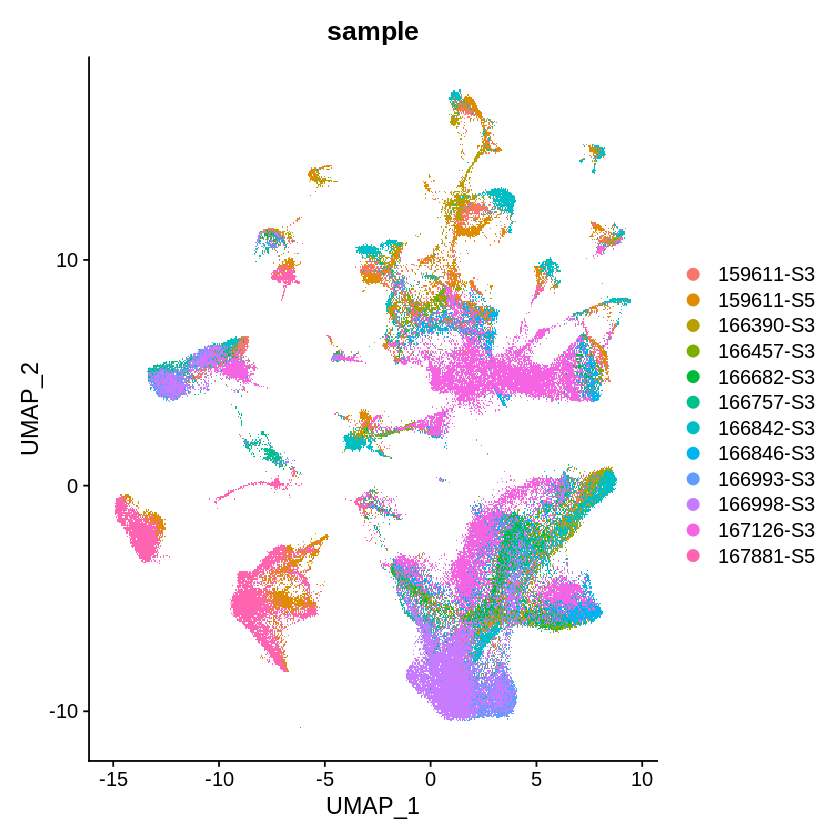

In [12]:
DimPlot(combined, group.by = "sample")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



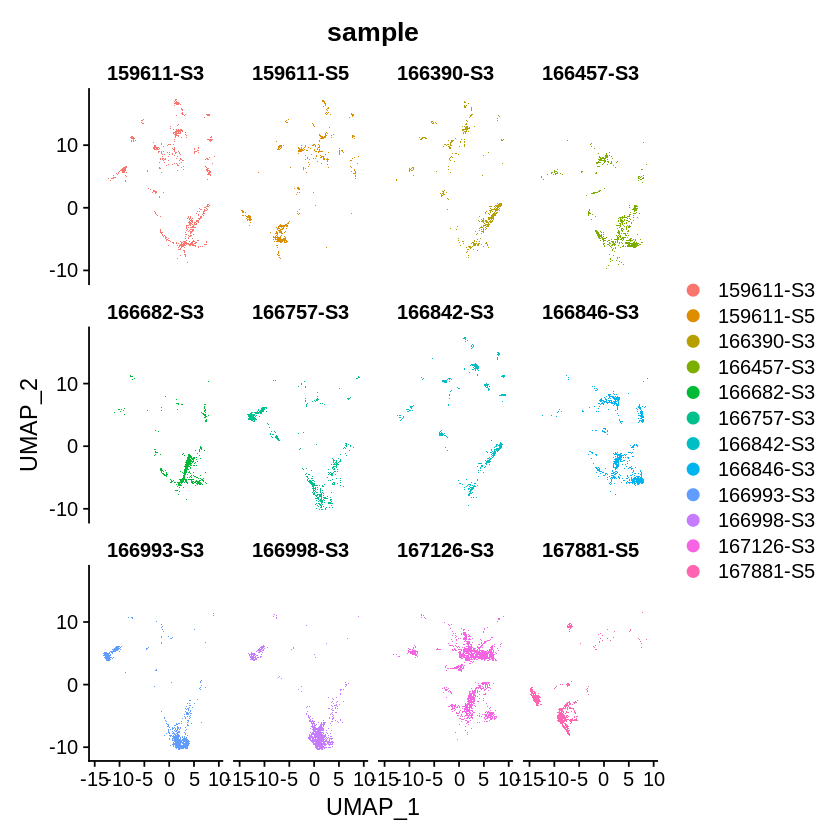

In [13]:
DimPlot(combined, group.by = "sample", split.by = "sample", ncol = 4)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



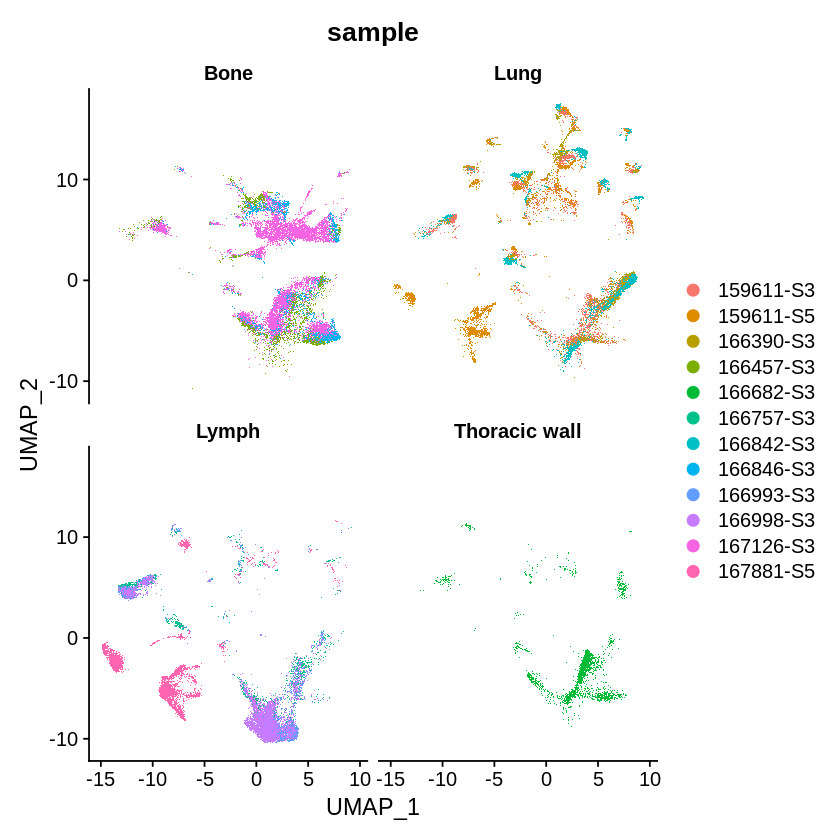

In [14]:
DimPlot(combined, group.by = "sample", split.by = "tissue", ncol = 2)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



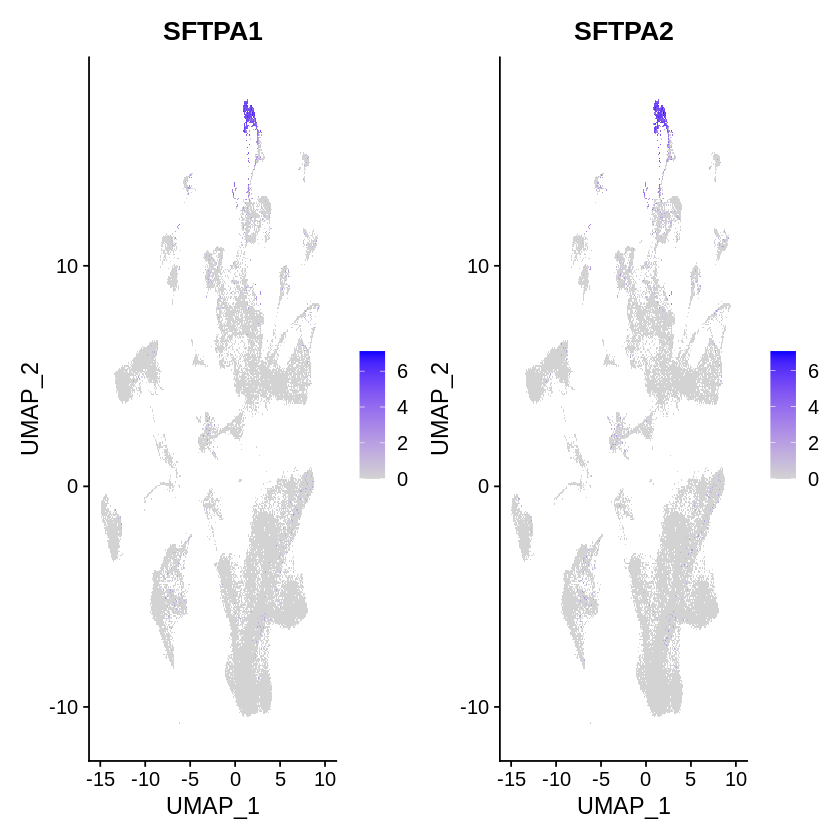

In [15]:
FeaturePlot(combined, reduction = "umap", features = c('SFTPA1', 'SFTPA2'))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



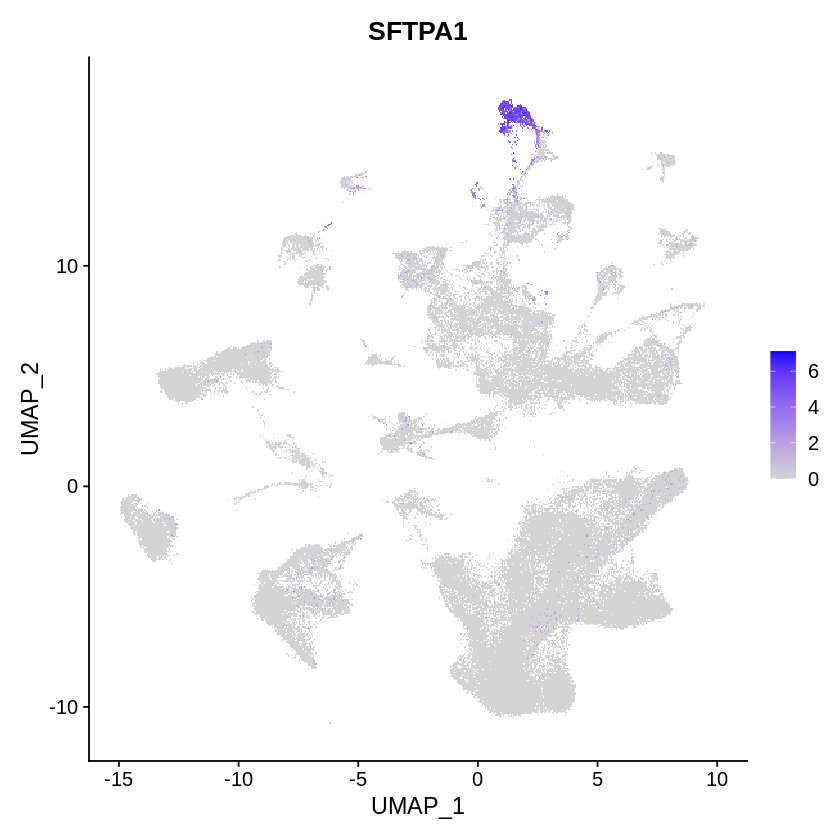

In [16]:
FeaturePlot(combined, reduction = "umap", features = 'SFTPA1')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



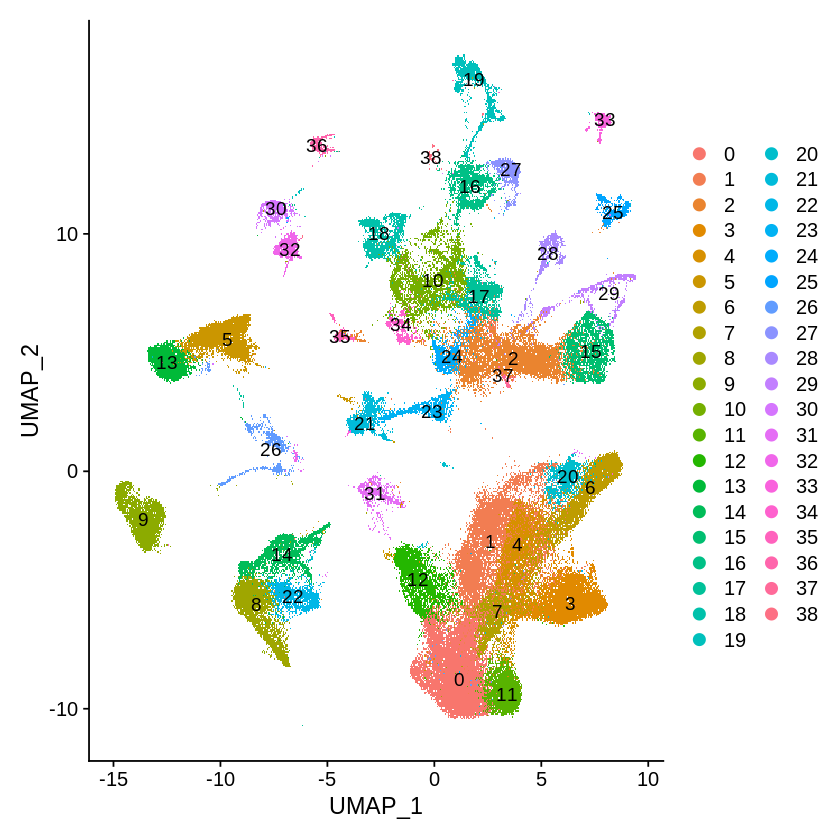

In [17]:
DimPlot(combined, label = T) 